# ruptures の model

- clinear
    - 各セグメントの開始点と終了点を結ぶトレンドからの距離の大きさをコスト値とする
- rbf
    - 周辺(セグメント内の各点)の差分量をコスト値とする
- ar
    - ar モデルで予測したときの難しさ（残差の大きさ）をコスト値とする


In [83]:
import numpy
import pandas
from datetime import datetime

import seaborn as sns

from matplotlib import pyplot


sns.set_theme(font="IPAexGothic")
pyplot.rcParams["figure.figsize"] = (20, 10)



In [84]:
import ruptures as rpt


In [85]:
# segmentation algorithm
rpt.Pelt        # Dynp で所定時間に終わらなさそうなときに代替として使う / コスト関数の大きさを踏まえて pen(penalty value) を設定する
    # penalty は、SVM の幅みたいなもの
rpt.KernelCPD
    # linear, rbf, cosine コストについて、Dynp, Pelt の C実装/高速版
rpt.Binseg
rpt.Window      # 変化点を敏感に捕まえたい(window少なめ)、鈍感にさせたい(window多め)などのバリエーションをもたせるのに使える
    # window 幅単位で区切ってセグメント化する。window//2 がストライド
rpt.Dynp        # 最適解の参考値としてほしい、計算時間次第で変化点の数を調整する
rpt.BottomUp


ruptures.detection.bottomup.BottomUp

In [86]:
from protuna import (
    build_prophet_model,
    Evaluator,
    Limitter,
    BestEstimator,
    setup_df_index,
    setup_limit,
    convert_wareki_to_seireki,
)

In [87]:
g_start_date = datetime.now()
g_start_date.strftime("%Y/%m/%d %T")


'2023/10/25 00:24:44'

In [88]:
url="https://www.mof.go.jp/jgbs/reference/interest_rate/data/jgbcm_all.csv"
_df = pandas.read_csv(url, header=1, encoding="shift-jis")
_df.tail()

,基準日,1年,2年,3年,4年,5年,6年,7年,8年,9年,10年,15年,20年,25年,30年,40年
12574,R5.9.25,-0.063,0.033,0.093,0.192,0.318,0.375,0.472,0.577,0.654,0.738,1.129,1.425,1.551,1.612,1.75
12575,R5.9.26,-0.063,0.034,0.093,0.193,0.317,0.379,0.490,0.596,0.669,0.752,1.133,1.429,1.555,1.619,1.75
12576,R5.9.27,-0.064,0.034,0.09,0.188,0.313,0.374,0.488,0.596,0.669,0.747,1.129,1.432,1.559,1.627,1.753
12577,R5.9.28,-0.055,0.044,0.104,0.209,0.331,0.395,0.507,0.615,0.692,0.765,1.142,1.441,1.567,1.634,1.76
12578,R5.9.29,-0.064,0.044,0.108,0.219,0.341,0.409,0.521,0.630,0.703,0.774,1.165,1.456,1.575,1.649,1.776


In [89]:
_df["ds"] = pandas.to_datetime(_df["基準日"].apply(convert_wareki_to_seireki))
_df[["基準日", "ds"]]


,基準日,ds
0,S49.9.24,1974-09-24
1,S49.9.25,1974-09-25
2,S49.9.26,1974-09-26
3,S49.9.27,1974-09-27
4,S49.9.28,1974-09-28
...,...,...
12574,R5.9.25,2023-09-25
12575,R5.9.26,2023-09-26
12576,R5.9.27,2023-09-27
12577,R5.9.28,2023-09-28


In [90]:
_df.replace('-', float('nan'), inplace=True)


In [91]:
_df.head(3)

,基準日,1年,2年,3年,4年,5年,6年,7年,8年,9年,10年,15年,20年,25年,30年,40年,ds
0,S49.9.24,10.327,9.362,8.83,8.515,8.348,8.29,8.24,8.121,8.127,NaN,NaN,NaN,NaN,NaN,NaN,1974-09-24
1,S49.9.25,10.333,9.364,8.831,8.516,8.348,8.29,8.24,8.121,8.127,NaN,NaN,NaN,NaN,NaN,NaN,1974-09-25
2,S49.9.26,10.34,9.366,8.832,8.516,8.348,8.29,8.24,8.122,8.128,NaN,NaN,NaN,NaN,NaN,NaN,1974-09-26


In [92]:
rate_cols = [col for col in _df.columns if col not in ["基準日", "ds"]]
rate_cols = ["1年", "5年", "10年", "20年"]
rate_cols


['1年', '5年', '10年', '20年']

In [93]:
_df[rate_cols] = _df[rate_cols].astype(float)
_df.head(3)

,基準日,1年,2年,3年,4年,5年,6年,7年,8年,9年,10年,15年,20年,25年,30年,40年,ds
0,S49.9.24,10.327,9.362,8.83,8.515,8.348,8.29,8.24,8.121,8.127,NaN,NaN,NaN,NaN,NaN,NaN,1974-09-24
1,S49.9.25,10.333,9.364,8.831,8.516,8.348,8.29,8.24,8.121,8.127,NaN,NaN,NaN,NaN,NaN,NaN,1974-09-25
2,S49.9.26,10.340,9.366,8.832,8.516,8.348,8.29,8.24,8.122,8.128,NaN,NaN,NaN,NaN,NaN,NaN,1974-09-26


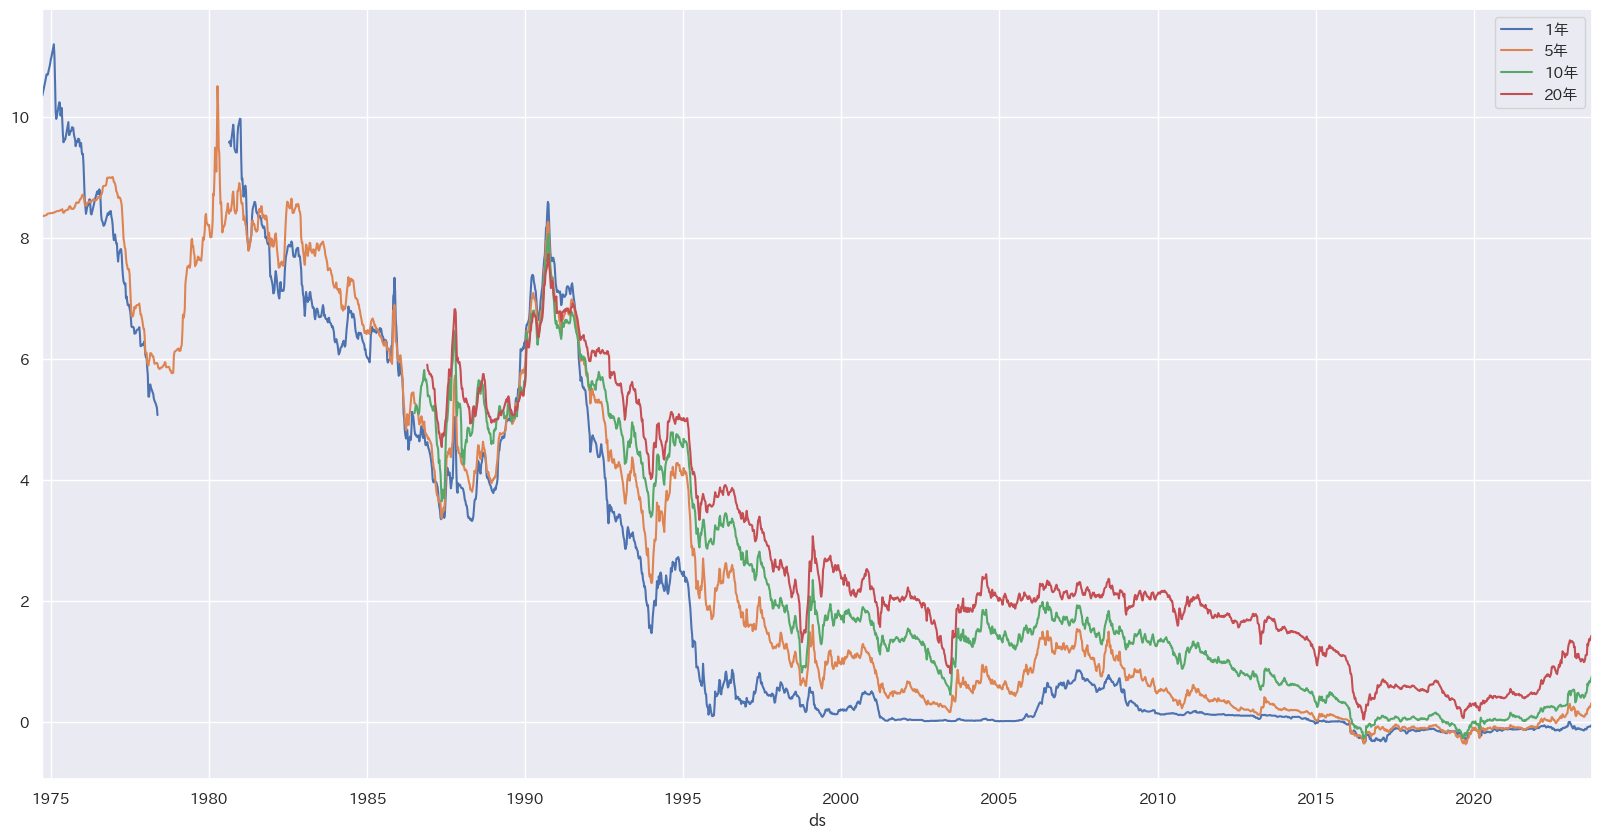

In [94]:
df = _df.copy()
df.index = pandas.to_datetime(df.ds)

df_weekly = df[rate_cols].resample("W-MON").mean()
df_weekly.plot()
pyplot.show()


In [95]:
df[["10年"]].dropna().head(3)

,10年
ds,
1986-07-05,5.103
1986-07-07,5.091
1986-07-08,5.123


In [96]:
df1 = df[["10年"]]["2020-01-01":]
df1.head(3)

,10年
ds,
2020-01-06,-0.025
2020-01-07,-0.008
2020-01-08,-0.013


In [157]:
model = "clinear"
# model = "linear"
# model = "ar"

# alg = rpt.Dynp(model=model).fit(df1.values)
alg = rpt.Pelt(model=model).fit(df1.values)
alg

In [158]:
len(df1)

916

In [165]:
# pred_bkps = alg.predict(n_bkps=10)
pred_bkps = alg.predict(pen=0.01)
pred_bkps


[10,
 15,
 30,
 40,
 45,
 50,
 60,
 70,
 80,
 85,
 115,
 140,
 150,
 180,
 210,
 235,
 260,
 275,
 280,
 285,
 290,
 300,
 305,
 320,
 325,
 345,
 350,
 360,
 375,
 400,
 440,
 465,
 480,
 495,
 505,
 515,
 530,
 535,
 545,
 550,
 555,
 585,
 595,
 620,
 635,
 645,
 670,
 675,
 720,
 730,
 740,
 745,
 750,
 765,
 775,
 780,
 790,
 795,
 805,
 815,
 825,
 830,
 840,
 850,
 865,
 870,
 875,
 885,
 890,
 895,
 900,
 916]

In [166]:
#  rpt.show.display(df1, [], pred_bkps, figsize=(12, 9))
# pyplot.show()


In [167]:
df1.head(3)

,10年
ds,
2020-01-06,-0.025
2020-01-07,-0.008
2020-01-08,-0.013


In [168]:
def plot_bkps(df: pandas.DataFrame, bkps: list[int]):
    signal: pandas.DataFrame = df1.copy()
    n_samples, n_features = signal.shape

    fig, axes = pyplot.subplots(n_features, sharex=True)
    axes = [axes] if n_features == 1 else axes

    for ax, sig in zip(axes, signal.T):
        signal.plot(ax=ax)

        for bkp in bkps:
            x = signal.index[bkp - 1]
            ax.axvline(x=x, color="b", linewidth=2, linestyle="--", alpha=0.2)

    fig.tight_layout()
    fig.show()


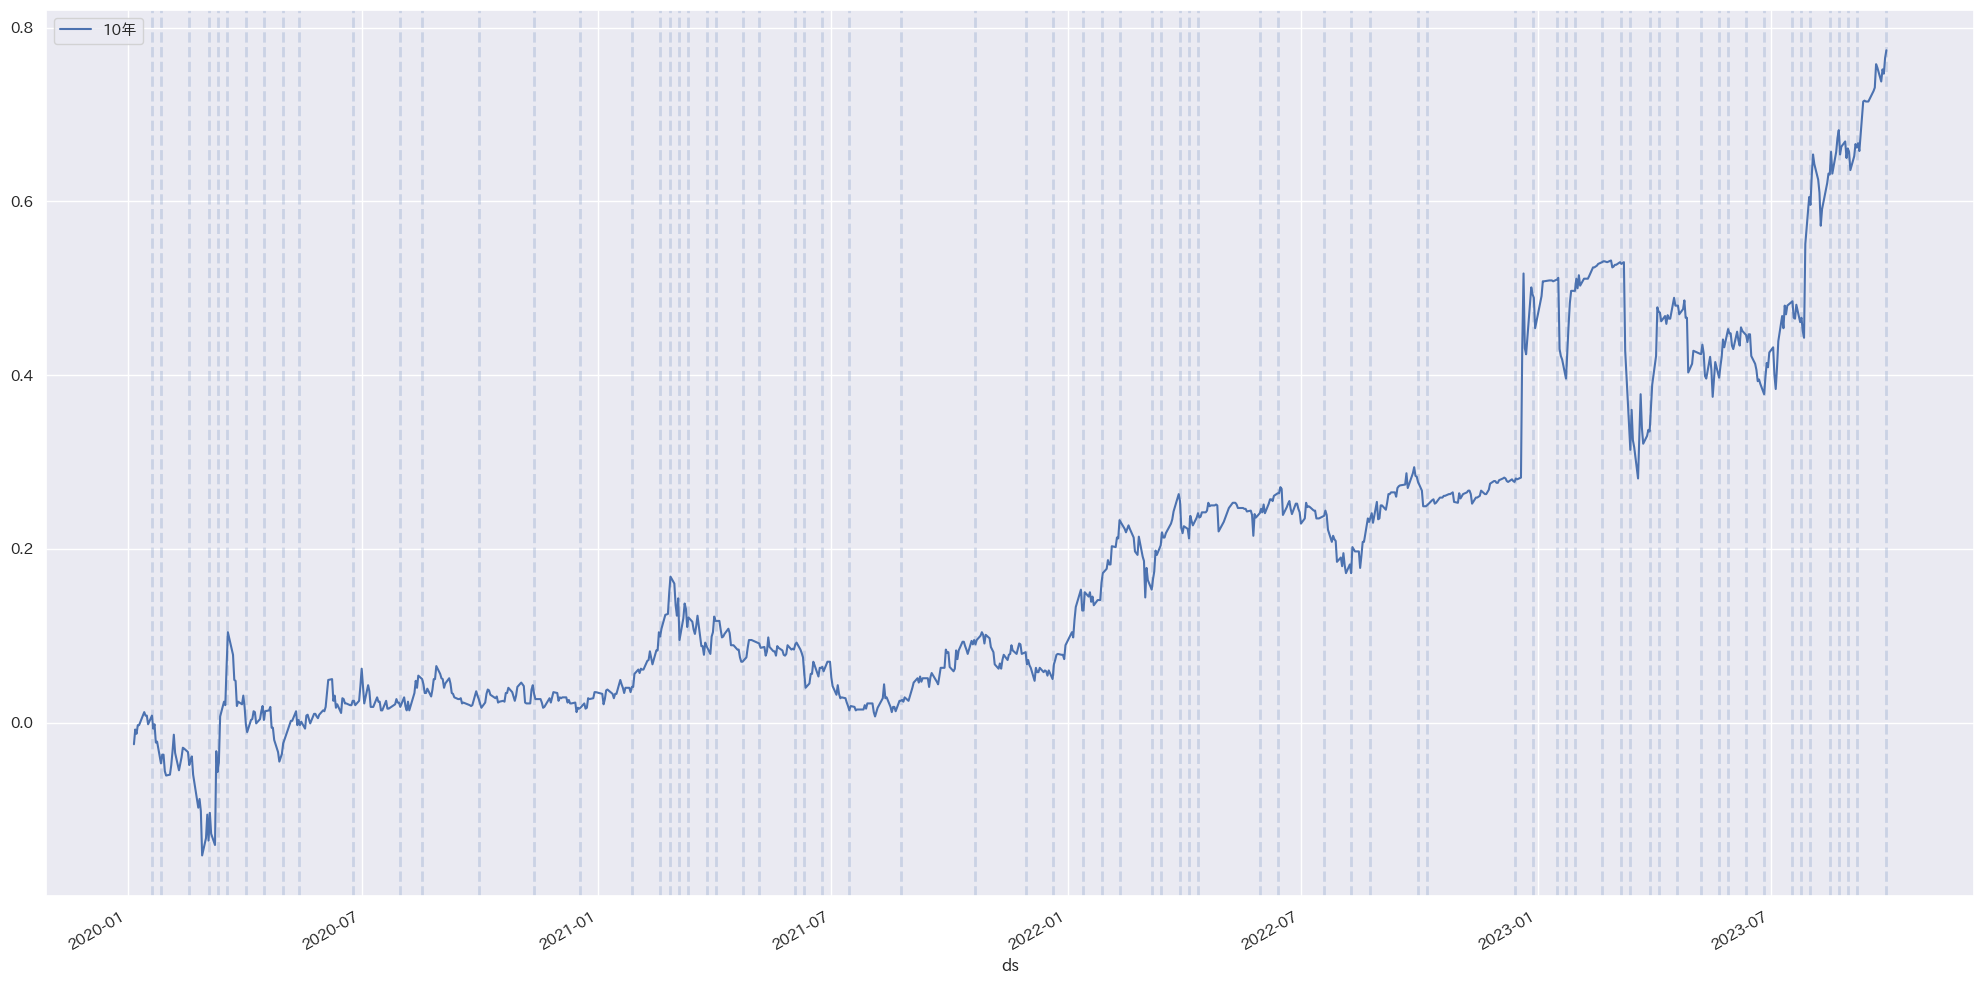

In [169]:
plot_bkps(df=df1.copy(), bkps=pred_bkps)

# 以下、ライブラリコードの理解用

In [170]:
signal = df1.copy()

In [171]:
from numpy.linalg import lstsq

start = 0
end = 5
_signal = signal.values[:, 0].reshape(-1, 1)
_covar = _signal[:, 1:]


In [172]:
_signal[:5]

array([[-0.025],
       [-0.008],
       [-0.013],
       [-0.003],
       [-0.003]])

In [173]:
_covar[:5]

array([], shape=(5, 0), dtype=float64)

In [174]:
y, X = _signal[start:end], _covar[start:end]
a, residual, b, c = lstsq(X, y, rcond=None)


In [175]:
df1.head(5)

,10年
ds,
2020-01-06,-0.025
2020-01-07,-0.008
2020-01-08,-0.013
2020-01-09,-0.003
2020-01-10,-0.003


In [176]:
residual

array([0.000876])

In [177]:
b, c

(0, array([], dtype=float64))

In [178]:
(y ** 2).sum()

0.0008760000000000002

In [179]:
from scipy.spatial.distance import pdist, squareform


In [180]:
K = pdist(signal, metric="sqeuclidean")

gamma = 1.0
# median heuristics
K_median = numpy.median(K)
if K_median != 0:
    # K /= K_median
    gamma = 1 / K_median
K *= gamma
numpy.clip(K, 1e-2, 1e2, K)  # clipping to avoid exponential under/overflow
_gram = numpy.exp(squareform(-K))


In [181]:
K_median

0.030975999999999997

In [182]:
(squareform(K))

array([[0.00000000e+00, 1.00000000e-02, 1.00000000e-02, ...,
        1.92401860e+01, 2.01478564e+01, 2.06095364e+01],
       [1.00000000e-02, 0.00000000e+00, 1.00000000e-02, ...,
        1.84021501e+01, 1.92900633e+01, 1.97418647e+01],
       [1.00000000e-02, 1.00000000e-02, 0.00000000e+00, ...,
        1.86466942e+01, 1.95404184e+01, 1.99951253e+01],
       ...,
       [1.92401860e+01, 1.84021501e+01, 1.86466942e+01, ...,
        0.00000000e+00, 1.04597107e-02, 2.35343492e-02],
       [2.01478564e+01, 1.92900633e+01, 1.95404184e+01, ...,
        1.04597107e-02, 0.00000000e+00, 1.00000000e-02],
       [2.06095364e+01, 1.97418647e+01, 1.99951253e+01, ...,
        2.35343492e-02, 1.00000000e-02, 0.00000000e+00]])

In [183]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

# Sample data
signal = np.array([0, 1, 2, 3, 4, 5, 6, 7])
order = 3

# Compute shape and strides
n_samples = len(signal)
strides = (signal.itemsize, signal.itemsize)
shape = (n_samples - order, order)

# Generate lagged variable using as_strided
lagged = as_strided(signal, shape=shape, strides=strides)
lagged


array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

In [184]:
strides

(8, 8)

In [185]:
# pad the first columns
lagged_after_padding = np.pad(lagged, ((order, 0), (0, 0)), mode="edge")
lagged_after_padding

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

In [186]:
# add intercept
covar = np.c_[lagged_after_padding, np.ones(n_samples)]
covar

array([[0., 1., 2., 1.],
       [0., 1., 2., 1.],
       [0., 1., 2., 1.],
       [0., 1., 2., 1.],
       [1., 2., 3., 1.],
       [2., 3., 4., 1.],
       [3., 4., 5., 1.],
       [4., 5., 6., 1.]])

In [187]:
signal[:order]


array([0, 1, 2])

In [188]:
signal[order]


3

In [189]:
signal[:order] = signal[order]
signal

array([3, 3, 3, 3, 4, 5, 6, 7])

In [190]:
from scipy.signal import argrelmax


argrelmax([], mode="wrap")


AttributeError: 'list' object has no attribute 'shape'